In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


In [2]:
#Reading the dataset. 
df = pd.read_csv('complaints.csv')

/var/folders/3n/y6l_g9s960lc_759jvhdhxp40000gn/T/ipykernel_20466/4050258152.py:2: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('complaints.csv')


In [3]:
#Data frame before performing data cleanup.
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-11-22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",OK,74447.0,Servicemember,NaN,Web,2022-11-22,In progress,Yes,NaN,6231498
1,2022-11-16,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,Experian Information Solutions Inc.,NJ,7093.0,NaN,NaN,Web,2022-11-16,In progress,Yes,NaN,6205383
2,2022-11-09,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Genesis FS Card Services, Inc.",TX,75038.0,NaN,NaN,Web,2022-11-09,Closed with explanation,Yes,NaN,6182699
3,2022-11-07,Mortgage,Other type of mortgage,Trouble during payment process,NaN,NaN,NaN,NORTHERN OHIO INVESTMENT COMPANY,MO,63031.0,NaN,Other,Web,2022-11-08,Untimely response,No,NaN,6173945
4,2022-11-07,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,NaN,NaN,"R & R Collection Service, Inc.",MO,64154.0,NaN,NaN,Phone,2022-11-07,Untimely response,No,NaN,6175998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096751,2017-02-09,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,I have disputed my debts several times with no...,NaN,Bonneville Billing and Collections,UT,84054.0,Servicemember,Consent provided,Web,2017-02-09,Closed with explanation,Yes,No,2334969
3096752,2015-04-29,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,My father died in XX/XX/XXXX. Left me his only...,NaN,"CITIBANK, N.A.",OK,74066.0,NaN,Consent provided,Web,2015-04-29,Closed with explanation,Yes,No,1352738
3096753,2017-03-31,Credit reporting,NaN,Credit reporting company's investigation,No notice of investigation status/result,cfbp i would Like to file a complaint on Exper...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MN,55379.0,NaN,Consent provided,Web,2017-03-31,Closed with non-monetary relief,Yes,Yes,2412926
3096754,2017-01-16,Credit reporting,NaN,Incorrect information on credit report,Account status,My husband and I are in the middle of an FHA S...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,30215.0,NaN,Consent provided,Web,2017-01-16,Closed with explanation,Yes,No,2292586


##### Since we are only focused on the products and complaint narratives, we will re-create the data frame using only the 'Product' and 'Consumer complaint narrative' attributes.

In [4]:
df = df[['Product' , 'Consumer complaint narrative']]

In [5]:
#Rename attributes of dataframe for simplicity.
df = df.rename(columns={'Product' : "Product",
                       'Consumer complaint narrative' : "Complaint"})

In [6]:
#Data frame after renaming attributes.
df

,Product,Complaint
0,"Credit reporting, credit repair services, or o...",NaN
1,"Credit reporting, credit repair services, or o...",NaN
2,Debt collection,NaN
3,Mortgage,NaN
4,Debt collection,NaN
...,...,...
3096751,Debt collection,I have disputed my debts several times with no...
3096752,Mortgage,My father died in XX/XX/XXXX. Left me his only...
3096753,Credit reporting,cfbp i would Like to file a complaint on Exper...
3096754,Credit reporting,My husband and I are in the middle of an FHA S...


In [7]:
df.groupby('Product').count()

,Complaint
Product,
Bank account or service,14885
Checking or savings account,54190
Consumer Loan,9470
Credit card,18838
Credit card or prepaid card,81787
Credit reporting,31588
"Credit reporting, credit repair services, or other personal consumer reports",514280
Debt collection,191946
"Money transfer, virtual currency, or money service",26556


##### Many of the products of the same category can be merged together into a single product category.

In [8]:
#Clean up data by renaming similar products into one category of products.
df['Product'].replace({'Bank account or service': 'Banking Services',
                       'Checking or savings account' : 'Banking Services',
                       'Consumer Loan' : 'Loans',
                       'Credit card' : 'Credit/Prepaid Cards',
                       'Credit card or prepaid card' : 'Credit/Prepaid Cards',
                       'Credit reporting' : 'Credit Reporting and Services',
                       'Credit reporting, credit repair services, or other personal consumer reports' : 'Credit Reporting and Services',
                       'Debt collection' : 'Debt Collection',
                       'Money transfer, virtual currency, or money service' : 'Banking Services',
                       'Money transfers' : 'Banking Services',
                       'Mortgage' : 'Mortgages',
                       'Other financial service' : 'Banking Services',
                       'Payday loan' : 'Loans',
                       'Payday loan, title loan, or personal loan' : 'Loans',
                       'Prepaid card' : 'Credit/Prepaid Cards',
                       'Student loan' : 'Loans',
                       'Vehicle loan or lease' : 'Loans',
                       'Virtual currency' : 'Crypto Currency'}, inplace=True)

#Refined products and their counts.
df.groupby('Product').count()

In [9]:
#Data frame with refined product categories.
df

,Product,Complaint
0,Credit Reporting and Services,NaN
1,Credit Reporting and Services,NaN
2,Debt Collection,NaN
3,Mortgages,NaN
4,Debt Collection,NaN
...,...,...
3096751,Debt Collection,I have disputed my debts several times with no...
3096752,Mortgages,My father died in XX/XX/XXXX. Left me his only...
3096753,Credit Reporting and Services,cfbp i would Like to file a complaint on Exper...
3096754,Credit Reporting and Services,My husband and I are in the middle of an FHA S...


### Cleanup data frame of null values.

In [10]:
#Create new df to hold only non-null values of Consumer complaint narratives.
df = df[pd.notnull(df['Complaint'])]

In [11]:
stop_words = stopwords.words('english') + list(string.punctuation)
stop_words += ["''", '""', '...', '``', '--', 'xxxx']

In [12]:
#Tokenize complaint data and remove stop words from complaint narrative.
def processComplaint(comp):
    tokens = nltk.word_tokenize(comp)
    removed_stop_words = [token.lower() for token in tokens if token.lower() not in stop_words]
    new_removed_stop_words = [word for word in removed_stop_words if word.isalpha()]
    
    return new_removed_stop_words

In [13]:
#Link words together.
def linkWords(words):
    linked_words = ''
    
    for w in words:
        linked_words += w + ' '
    
    return linked_words.strip()

In [14]:
lm = WordNetLemmatizer()

In [15]:
#Group variants of the same word and merge complaints.
def groupVariants(words):
    words = [word for word in words if word is not np.nan]
    
    lem_list = []
    
    for idx, word in enumerate(words):
        lem_list.append(lm.lemmatize(word))
    
    linked_str = linkWords(lem_list)
    
    return linked_str

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/ganesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ganesh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
# Eliminate stop words and group variants of words.
for i in range(len(df)):
    processed_complaints = processComplaint(df['Complaint'].iloc[i])
    complaint = groupVariants(processed_complaints)
    
    df['Complaint'].iloc[i] = complaint

    #Keep track of processed complaints.
    if i % 5000 == 0:
        print(f'Processed Row: {i}')

/var/folders/3n/y6l_g9s960lc_759jvhdhxp40000gn/T/ipykernel_20466/553799132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Complaint'].iloc[i] = complaint


Processed Row: 0
Processed Row: 5000
Processed Row: 10000
Processed Row: 15000
Processed Row: 20000
Processed Row: 25000
Processed Row: 30000
Processed Row: 35000
Processed Row: 40000
Processed Row: 45000
Processed Row: 50000
Processed Row: 55000
Processed Row: 60000
Processed Row: 65000
Processed Row: 70000
Processed Row: 75000
Processed Row: 80000
Processed Row: 85000
Processed Row: 90000
Processed Row: 95000
Processed Row: 100000
Processed Row: 105000
Processed Row: 110000
Processed Row: 115000
Processed Row: 120000
Processed Row: 125000
Processed Row: 130000
Processed Row: 135000
Processed Row: 140000
Processed Row: 145000
Processed Row: 150000
Processed Row: 155000
Processed Row: 160000
Processed Row: 165000
Processed Row: 170000
Processed Row: 175000
Processed Row: 180000
Processed Row: 185000
Processed Row: 190000
Processed Row: 195000
Processed Row: 200000
Processed Row: 205000
Processed Row: 210000
Processed Row: 215000
Processed Row: 220000
Processed Row: 225000
Processed Row

In [18]:
#Output processed complaints file.
df.to_csv('processed_complaints.csv')

# Working with processed complaint data set.

In [19]:
#Read new processed complaint data set.
ndf = pd.read_csv('processed_complaints.csv')

In [20]:
ndf

,Unnamed: 0,Product,Complaint
0,38,Debt Collection,owe money never received bill indicating balan...
1,39,Debt Collection,attempting collect fund valuation service prov...
2,41,Credit Reporting and Services,experian didnt consent inquiry also name incor...
3,68,Banking Services,citibank froze account contained time make col...
4,129,Credit Reporting and Services,accordance fair credit reporting act account v...
...,...,...,...
1112415,3096750,Credit/Prepaid Cards,automated call capital one call home phone exc...
1112416,3096751,Debt Collection,disputed debt several time resolution submitte...
1112417,3096752,Mortgages,father died left son belonging also single mot...
1112418,3096753,Credit Reporting and Services,cfbp would like file complaint experian report...


In [21]:
#Eliminate 'Unnamed:0' column.
ndf.drop(['Unnamed: 0'], axis=1, inplace=True)

In [23]:
#Check how many null values are in the Complaint column.
ndf['Complaint'].isnull().sum()

81

In [24]:
#Eliminate all null values.
ndf = ndf.dropna()

In [25]:
#Check how many null values are in the Complaint column.
ndf['Complaint'].isnull().sum()

0

In [29]:
ndf.shape

(1112339, 2)

In [30]:
ndf['Product'].unique()

array(['Debt Collection', 'Credit Reporting and Services',
       'Banking Services', 'Mortgages', 'Credit/Prepaid Cards', 'Loans',
       'Crypto Currency'], dtype=object)

# Convert products to digits in order to apply ML techniques.

In [33]:
ndf['Product'].replace({'Debt Collection' : 0, 
                        'Credit Reporting and Services' : 1,
                        'Banking Services' : 2,
                        'Mortgages' : 3,
                        'Credit/Prepaid Cards' : 4,
                        'Loans' : 5,
                        'Crypto Currency' : 6}, inplace=True)

/var/folders/3n/y6l_g9s960lc_759jvhdhxp40000gn/T/ipykernel_20466/3472038189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['Product'].replace({'Debt Collection' : 0,


In [34]:
ndf

,Product,Complaint
0,0,owe money never received bill indicating balan...
1,0,attempting collect fund valuation service prov...
2,1,experian didnt consent inquiry also name incor...
3,2,citibank froze account contained time make col...
4,1,accordance fair credit reporting act account v...
...,...,...
1112415,4,automated call capital one call home phone exc...
1112416,0,disputed debt several time resolution submitte...
1112417,3,father died left son belonging also single mot...
1112418,1,cfbp would like file complaint experian report...


In [92]:
#Create train and test sets.
x = ndf['Complaint']
y = ndf['Product']

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

In [94]:
print("Training set size:" , x_train.shape)
print("Test set size:" , x_test.shape)

Training set size: (889871,)
Test set size: (222468,)


As expected, the training set has more data than the test set.

# Using TF-IDF to convert text into features.

In [111]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=1000000)
tfidf_x_train = tfidf.fit_transform(x_train)
tfidf_x_test = tfidf.transform(x_test)

# Classification model using Naive Bayes classifier.

In [112]:
nb = MultinomialNB()
nb.fit(tfidf_x_train, y_train)

MultinomialNB()

In [113]:
#Predictions for training and testing set.
pred_y_train = nb.predict(tfidf_x_train)
pred_y_test = nb.predict(tfidf_x_test)

In [114]:
print('Training prediction accuracy: ', accuracy_score(y_train, pred_y_train))
print('Testing prediction accuracy: ', accuracy_score(y_test, pred_y_test))

Training prediction accuracy:  0.8656176007533676
Testing prediction accuracy:  0.8518888109750615


In [115]:
print('Classification Report for Naive Bayes (Training Data)\n', classification_report(y_train, pred_y_train))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Naive Bayes (Training Data)
               precision    recall  f1-score   support

           0       0.82      0.77      0.79    153511
           1       0.88      0.93      0.91    436362
           2       0.87      0.90      0.88     77940
           3       0.88      0.93      0.91     78388
           4       0.81      0.76      0.79     81704
           5       0.87      0.64      0.74     61954
           6       0.00      0.00      0.00        12

    accuracy                           0.87    889871
   macro avg       0.74      0.70      0.72    889871
weighted avg       0.86      0.87      0.86    889871



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
print('Classification Report for Naive Bayes (Test Data)\n', classification_report(y_test, pred_y_test))

Classification Report for Naive Bayes (Test Data)
               precision    recall  f1-score   support

           0       0.81      0.75      0.78     38416
           1       0.87      0.93      0.90    109456
           2       0.85      0.88      0.86     19478
           3       0.86      0.92      0.89     19356
           4       0.79      0.73      0.76     20368
           5       0.86      0.60      0.71     15390
           6       0.00      0.00      0.00         4

    accuracy                           0.85    222468
   macro avg       0.72      0.69      0.70    222468
weighted avg       0.85      0.85      0.85    222468



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix for Naive Bayes (Train)


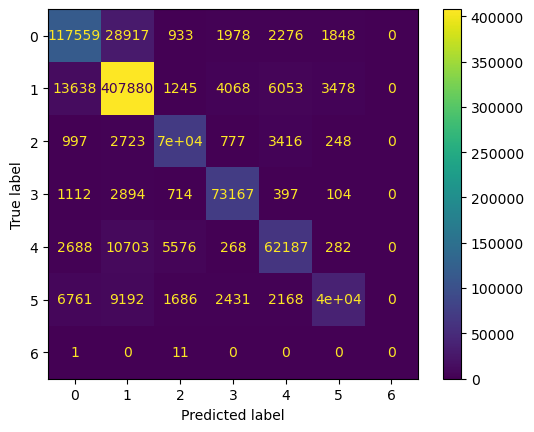

In [127]:
cmat_train = confusion_matrix(y_train, pred_y_train)

cmat_train_disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cmat_train)
cmat_train_disp.plot()

print('Confusion Matrix for Naive Bayes (Train)')
plt.show()

Confusion Matrix for Naive Bayes (Test)


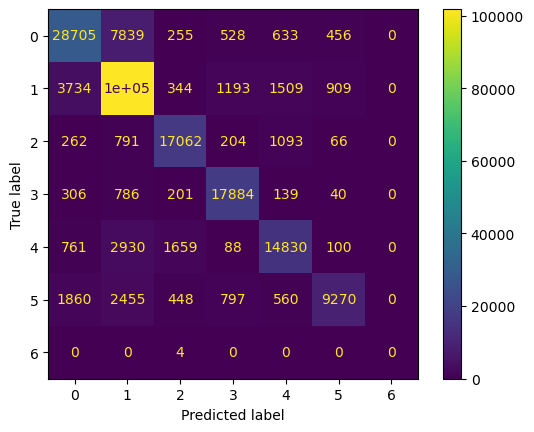

In [128]:
cmat_test = confusion_matrix(y_test, pred_y_test)

cmat_test_disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cmat_test)
cmat_test_disp.plot()

print('Confusion Matrix for Naive Bayes (Test)')
plt.show()